In [2]:
import pandas 
import numpy

import matplotlib.pyplot
import seaborn

import networkx

from scipy.stats import ranksums

from utils import parse_interactome, parse_causal_genes

In [3]:
def parse_scores(scores_file, causal_genes):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            # skip causal genes
            if causal_genes.get(gene) == 1:
                continue
            scores[gene] = float(score)

    return scores

In [4]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            gene, score = line_splitted
            scores_left_out[gene] = float(score)
        
    return scores_left_out

In [5]:
def concatenate_scores(scores, scores_left_out):
    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, p_value = ranksums(df_scores['score'].values, df_scores_left_out['score'].values)

    return df_compare, p_value

In [6]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [7]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Load and parse the necessary data

In [8]:
PHENOTYPE = "MMAF"

In [9]:
interactome, genes = parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

causal_genes = parse_causal_genes(causal_genes_file="/home/kubicaj/calc/input/causalGenes_allPhenotypes.csv",
                                  canonical_genes_file="/home/kubicaj/calc/input/canonicalGenes.tsv",
                                  genes=genes)

In [152]:
# find distances between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

nonCausal_genes_list = [k for k, v in causal_genes.items() if v == 0]
causal_genes_list = [k for k, v in causal_genes.items() if v == 1]

for source_node in nonCausal_genes_list:
    dict_tmp = {}

    for target_node in causal_genes_list:
        try:
            distance = networkx.shortest_path_length(interactome, source_node, target_node)
            dict_tmp[target_node] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source_node] = dict_tmp

print(f"Longest distance between {PHENOTYPE} and non-{PHENOTYPE} gene: {longest_distance}")

Longest distance between MMAF and non-MMAF gene: 10


#### Analyze leave-one-out results: newCentrality_v4.py d=5

In [19]:
scores = parse_scores("/home/kubicaj/calc/output/scores.tsv", causal_genes)

In [20]:
scores_left_out = parse_leave_one_out("/home/kubicaj/calc/output/leave_one_out_d5/left_out_scores.tsv")

In [21]:
df_compare, p_value = concatenate_scores(scores, scores_left_out)

(0.0, 0.01)

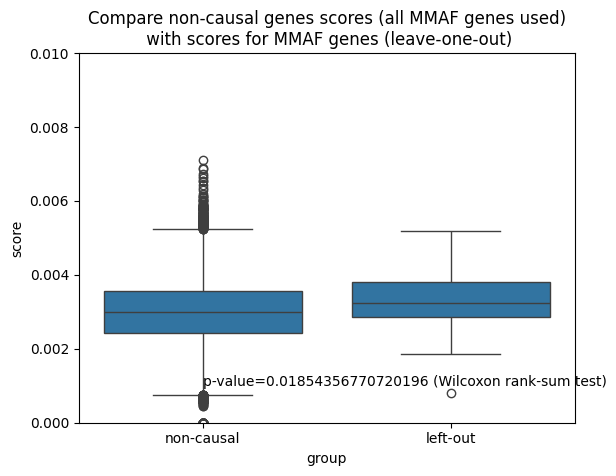

In [22]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)")
matplotlib.pyplot.ylim(0, 0.01)

#### Analyze leave-one-out results: newCentrality_v4.py d=10

In [15]:
scores = parse_scores("/home/kubicaj/calc/output/scores_d10.tsv", causal_genes)

In [16]:
scores_left_out = parse_leave_one_out("/home/kubicaj/calc/output/leave_one_out_d10/left_out_scores.tsv")

In [17]:
df_compare, p_value = concatenate_scores(scores, scores_left_out)

(0.0, 0.005)

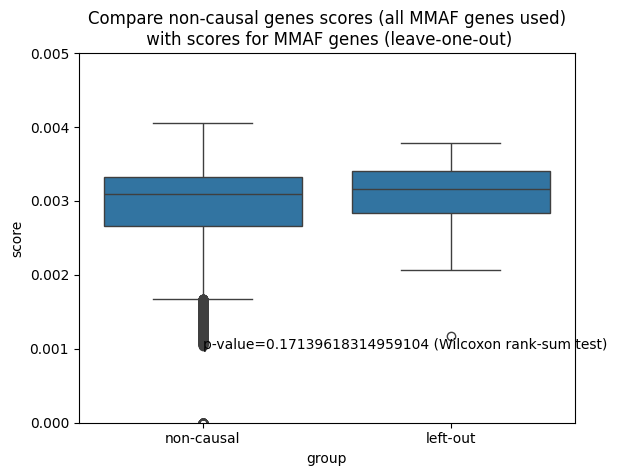

In [18]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)")
matplotlib.pyplot.ylim(0, 0.005)

## Scores analysis newCentrality_v4 d=10

In [128]:
scores = parse_scores("/home/kubicaj/calc/output/scores_d10.tsv", causal_genes)

In [129]:
scores_sorted = dict(sorted(scores.items(), key=lambda v: v[1], reverse=True))

In [130]:
# get more info about each node (degree, causal genes at distances)
for n, score in scores_sorted.items():
    scores_sorted[n] = [score, 
                        interactome.degree(n), 
                        (n in causal_genes_list),
                        causal_genes_at_distance(dict_distances, n, 1), 
                        causal_genes_at_distance(dict_distances, n, 2),
                        causal_genes_at_distance(dict_distances, n, 3),
                        causal_genes_at_distance(dict_distances, n, 4)]

df = pandas.DataFrame.from_dict(scores_sorted, 
                                orient='index', 
                                columns=['score', 'degree', 'isCausal', 'causal genes at d=1', 'causal genes at d=2', 'causal genes at d=3', 'causal genes at d=4'])

In [131]:
df.head(10)

,score,degree,isCausal,causal genes at d=1,causal genes at d=2,causal genes at d=3,causal genes at d=4
ENSG00000057704,0.004057,1,False,0,0,2,5
ENSG00000198298,0.003978,1,False,0,0,1,7
ENSG00000089639,0.003973,1,False,0,0,3,12
ENSG00000188408,0.003964,1,False,0,0,1,8
ENSG00000182791,0.003953,1,False,0,2,5,17
ENSG00000163440,0.003948,1,False,0,0,6,12
ENSG00000162994,0.003945,1,False,0,0,3,10
ENSG00000213366,0.003925,1,False,0,0,1,8
ENSG00000150676,0.003920,1,False,0,1,4,19
ENSG00000182793,0.003916,2,False,0,1,3,7


Text(0.5, 1.0, 'New centrality v4 scores vs. node degree')

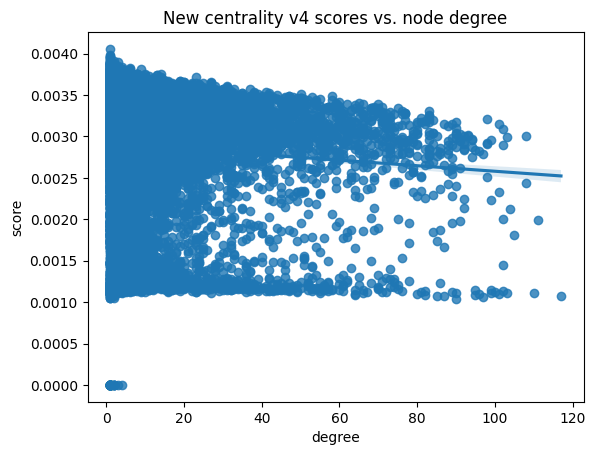

In [132]:
seaborn.regplot(data=df, x="degree", y="score")
matplotlib.pyplot.title("New centrality v4 scores vs. node degree")

Text(0.5, 1.0, 'New centrality scores')

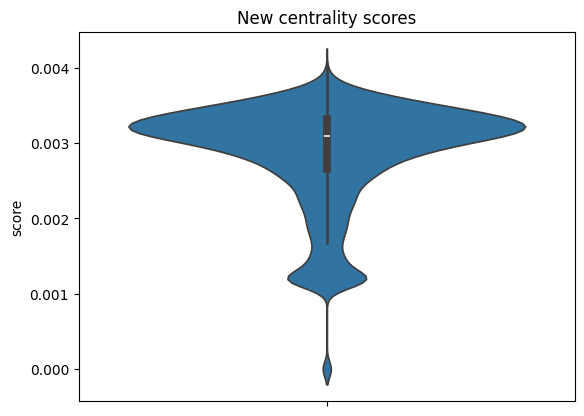

In [133]:
seaborn.violinplot(data=df, y='score')
matplotlib.pyplot.title("New centrality scores")

<Axes: xlabel='causal genes at d=1', ylabel='score'>

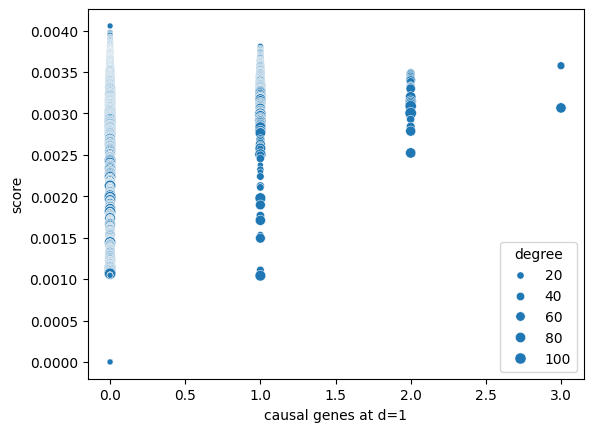

In [143]:
seaborn.scatterplot(data=df, x='causal genes at d=1', y='score', size='degree')

<Axes: xlabel='causal genes at d=2', ylabel='score'>

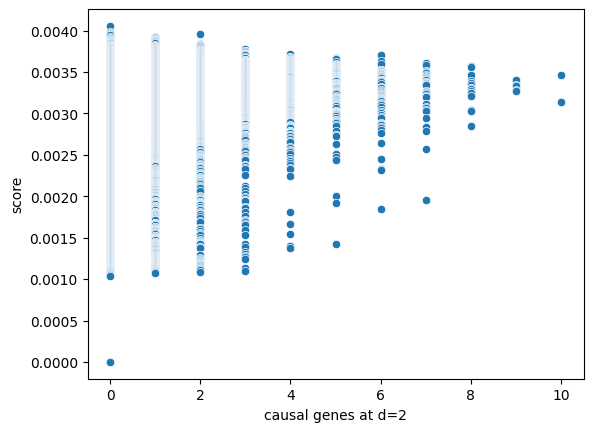

In [135]:
seaborn.scatterplot(data=df, x='causal genes at d=2', y='score')

<Axes: xlabel='causal genes at d=3', ylabel='score'>

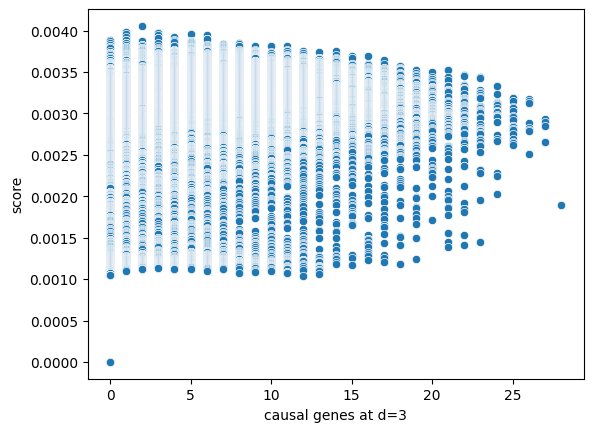

In [136]:
seaborn.scatterplot(data=df, x='causal genes at d=3', y='score')

<Axes: xlabel='causal genes at d=4', ylabel='score'>

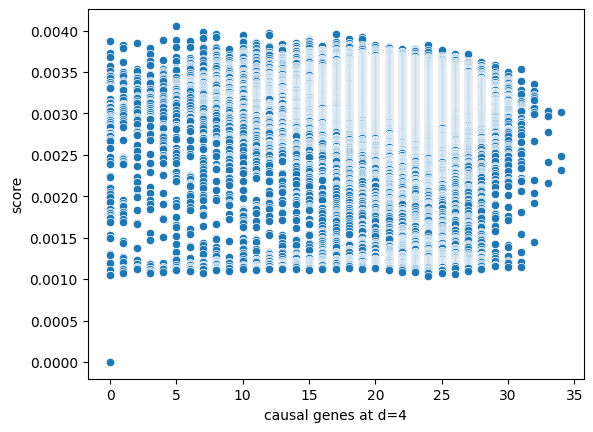

In [137]:
seaborn.scatterplot(data=df, x='causal genes at d=4', y='score')

#### Analyze new candidates from 13/02/2024

In [138]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [139]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [140]:
# check scores of new candidates
scores_new_candidates = {n: scores.get(n) for n in new_candidates}

In [141]:
scores_new_candidates

{'ENSG00000162994': 0.0039445908435962376,
 'ENSG00000025293': 0.003219306561529913,
 'ENSG00000164287': 0.003646300496750904,
 'ENSG00000188732': 0.003521135139688866,
 'ENSG00000128310': 0.0025425133358805436,
 'ENSG00000165115': 0.003289165555748102,
 'ENSG00000180376': 0.00378611312244383,
 'ENSG00000133101': 0.0032363772612458673,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 0.003415759411848175,
 'ENSG00000136449': 0.003389562454110493,
 'ENSG00000078814': 0.0035593080580242006,
 'ENSG00000165698': 0.003033268216487309,
 'ENSG00000170469': 0.003036189039570307,
 'ENSG00000132122': 0.0034416608698618944,
 'ENSG00000139908': 0.0028614806468860742,
 'ENSG00000120440': 0.0019240502854398342}

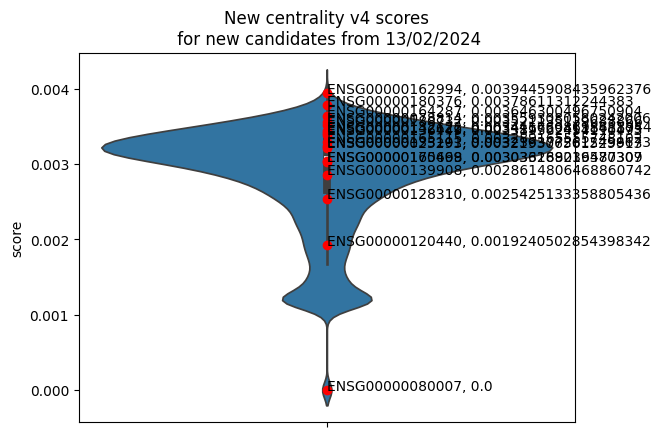

In [142]:
seaborn.violinplot(data=df, y='score')
matplotlib.pyplot.title("New centrality v4 scores\n for new candidates from 13/02/2024")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")